# Analyse mit Lime (Local Interpretable Model-Agnostic Explanations)
LIME ist dafür da, eine einzelne Entscheidung des Systems lokal zu analysieren. Es ist Modell-Agnostisch und nutzt ein Surrogate Model (Ersatzmodell).

Deswegen habe ich bestimmte Bilder herausgesucht, welche ich analysieren möchte. Ziel ist es herauszufinden, welche Faktoren zu einer Entscheidung des Modells führen können.

### Laden des Modells und der Pakete

In [ ]:
import sys
sys.path.append('..')

from src.models.modelManager import ModelManager

model_manager = ModelManager()
model = model_manager.load_model() 

from src.config import *
from src.visualization.visualize import visualize_detections, load_image_from_url, show_grid

from lime import lime_image



⬇ Lade Modell: football-ball-detection-rejhg/4
  (Verwendet Cache falls bereits heruntergeladen)


✓ Modell geladen


### Laden der Bilder

In [5]:
# Laden der Gesamten Bilder 
total_images = list(DATASET_PATH.rglob("*.jpg"))
images_length = len(total_images)
print(images_length)

4948


### Selektion der Bilder
- Es ist natürlich zeitlich unmöglich alle Bilder des Datensatzes zu analysieren. Deswegen beschränke ich mich auf bestimmte Bilder, welche interessant wirken
- Dabei nehme ich möglichst verschiedene Szenen und Teams (Farben etc.)
- Zusätzlich schaue ich, dass ich von den vier Kategorien mindestens eins dabei habe
    - True Positive
    - False Positive (dürften relativ schwer zu finden sein)
    - True Negative 
    - False Negative
--> wobei das Modell natürlich nicht einfach nur einen Binärwert, sondern eine Confidence zurückgibt.

Weil das Modell eine hohe Precision (97.4%) aber einen vergleichsweise geringen Recall (78%) besitzt sind vor allem auch die FN interessant.

✓ Verwendete Indizes: [4298, 1390, 362, 3029, 4247, 726, 4257, 4859, 1288]


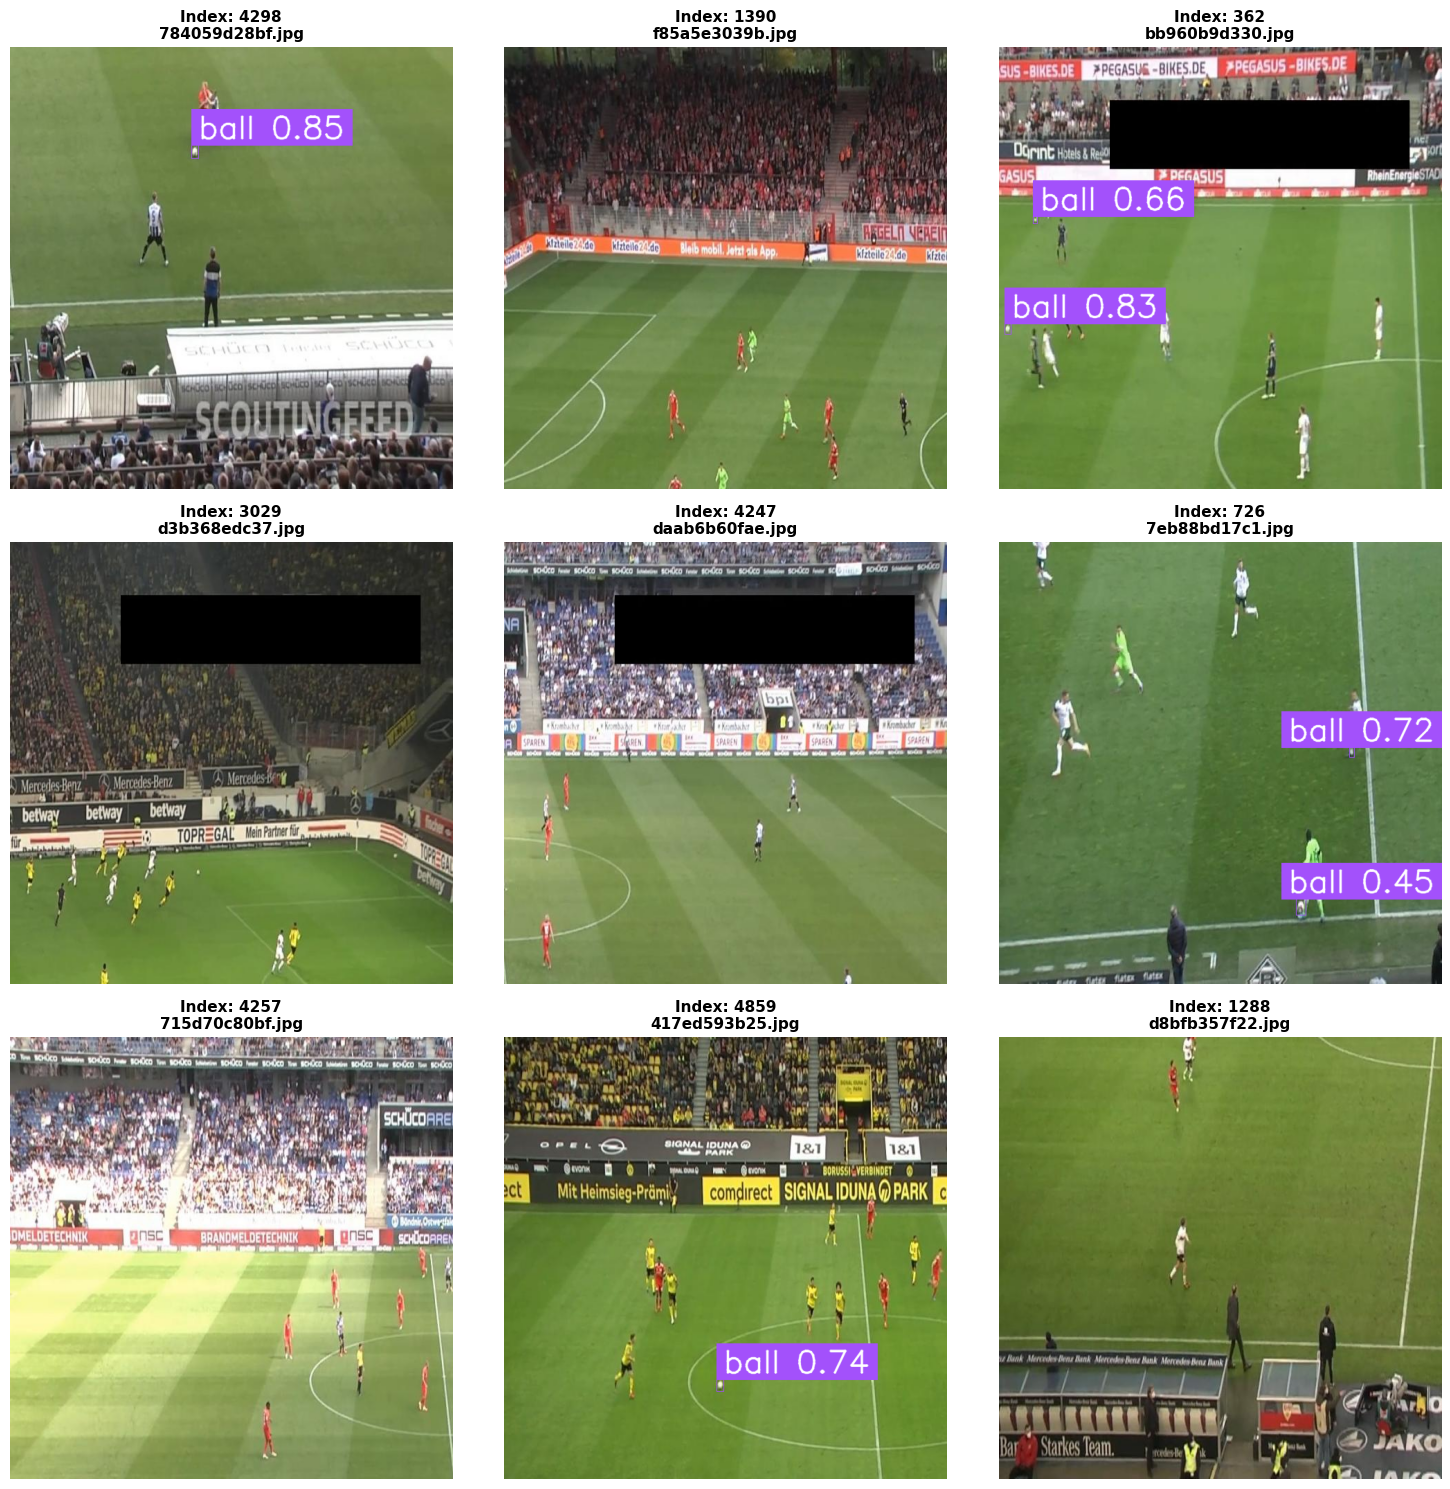

In [41]:
IMAGES_INDICES = [4298, 1390, 362, 3029, 4247, 726, 4257, 4859, 1288] 

show_grid(total_images, model_manager, IMAGES_INDICES)

### Numpy Wrapper Function und Lime Explainer

In [47]:
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from PIL import Image

# Initialisiere den Explainer EINMAL global
explainer = lime_image.LimeImageExplainer()

def detection_as_classification_prediction(images):
    """
    Wandelt die Detection-Ausgabe in ein Format um, das LIME versteht.
    
    Input: Liste von Numpy-Bildern (von LIME generiert)
    Output: Matrix (Anzahl_Bilder x 2) -> [Wahrscheinlichkeit_Leer, Wahrscheinlichkeit_Ball]
    """
    results_list = []
    
    # LIME gibt uns oft einen Batch von Bildern
    for numpy_img in images:
        # 1. Konvertierung: Numpy (LIME) -> PIL (Dein Model)
        # LIME nutzt float64 oder uint8, wir stellen sicher, dass es uint8 für PIL ist
        if numpy_img.max() > 1:
            pil_img = Image.fromarray(numpy_img.astype('uint8'))
        else:
            # Falls LIME float 0-1 liefert
            pil_img = Image.fromarray((numpy_img * 255).astype('uint8'))

        # 2. Inference
        # Wir fangen Fehler ab, falls LIME ein komplett graues Bild schickt, das das Modell verwirrt
        try:
            inference_result = model_manager.infer(pil_img)
            predictions = inference_result.predictions
        except:
            predictions = []

        # 3. Den "Score" berechnen
        # Wir suchen die höchste Konfidenz für einen Ball in diesem Bild
        max_confidence = 0.0
        
        for pred in predictions:
            # Optional: Hier könnte man noch prüfen if pred.class_name == 'ball'
            if pred.confidence > max_confidence:
                max_confidence = pred.confidence
        
        # 4. Formatierung für LIME (Binary Classification style)
        # [Wahrscheinlichkeit dagegen, Wahrscheinlichkeit dafür]
        results_list.append([1.0 - max_confidence, max_confidence])
        
    return np.array(results_list)

print("✓ LIME Explainer und Wrapper-Funktion bereit.")

✓ LIME Explainer und Wrapper-Funktion bereit.


### Lime Analysefunktion
- so konzipiert, dass sie im Laufe des Projekts immer wieder aufgerufen werden kann, um einzelne BIlder zu analysieren

In [ ]:
def analyze_with_lime(image_index, num_samples=100):
    """
    Führt eine vollständige LIME-Analyse für ein bestimmtes Bild durch.
    
    Args:
        image_index (int): Index des Bildes in der total_images Liste.
        num_samples (int): Anzahl der LIME-Durchläufe (höher = genauer, aber langsamer).
    """
    
    # 1. Bild laden
    try:
        img_path = total_images[image_index]
    except IndexError:
        print(f"❌ Fehler: Index {image_index} existiert nicht.")
        return

    print("\n" + "="*60)
    print(f"🧐 STARTE ANALYSE FÜR BILD {image_index}")
    print(f"📂 Datei: {img_path.name}")
    print("="*60)

    original_image = Image.open(img_path)
    img_numpy = np.array(original_image)

    # 2. LIME Berechnung
    print(f"⏳ LIME arbeitet... ({num_samples} Permutationen)")
    
    try:
        explanation = explainer.explain_instance(
            image=img_numpy, 
            classifier_fn=detection_as_classification_prediction, 
            top_labels=1, 
            hide_color=0, # Schwarz für ausgeblendete Bereiche
            num_samples=num_samples
        )
        print("✓ LIME Berechnung erfolgreich!")
    except Exception as e:
        print(f"❌ Fehler bei der LIME-Berechnung: {e}")
        return

    # 3. Visualisierung vorbereiten
    # Wir holen uns das Bild mit Overlay
    # positive_only=False -> Zeigt auch Rote Bereiche (was gegen Ball spricht)
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0], 
        positive_only=False, 
        num_features=5, 
        hide_rest=False
    )
    
    # Wahrscheinlichkeit für das Originalbild holen
    original_score = explanation.local_pred[0] if hasattr(explanation, 'local_pred') else "N/A"

    # 4. Plotten (Links: Original+Box, Rechts: LIME)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Links: Was sieht das Modell? (Deine Detection Visualisierung)
    results = model_manager.infer(original_image)
    annotated_img = visualize_detections(original_image, results, labels_on_image=True)
    ax1.imshow(annotated_img)
    ax1.set_title(f"Original Detection\n(Index: {image_index})", fontsize=12, fontweight='bold')
    ax1.axis('off')

    # Rechts: Warum entscheidet es so? (LIME)
    ax2.imshow(mark_boundaries(temp / 255.0, mask))
    ax2.set_title(f"LIME Erklärung\nGrün = Ball-Indikator | Rot = Gegen-Indikator", fontsize=12, fontweight='bold')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()
    
    print(f"📝 Analyse beendet.\n")

# Umsetzung der Analyse mit den ausgewählten Bildern
### Erste Erkenntnis: Die Verwendete LIME-Funktion ist nicht deterministisch (sollte sie auch nicht sein)
- Unterschiedliche Ausgaben trotz selbem Input und Parameter


🧐 STARTE ANALYSE FÜR BILD 4298
📂 Datei: c01561_0_mp4-0035_jpg.rf.9ac049933f21756fa94bc784059d28bf.jpg
⏳ LIME arbeitet... (100 Permutationen)
   Dies kann je nach CPU/GPU einige Sekunden dauern...


100%|██████████| 100/100 [04:42<00:00,  2.82s/it]


✓ LIME Berechnung erfolgreich!


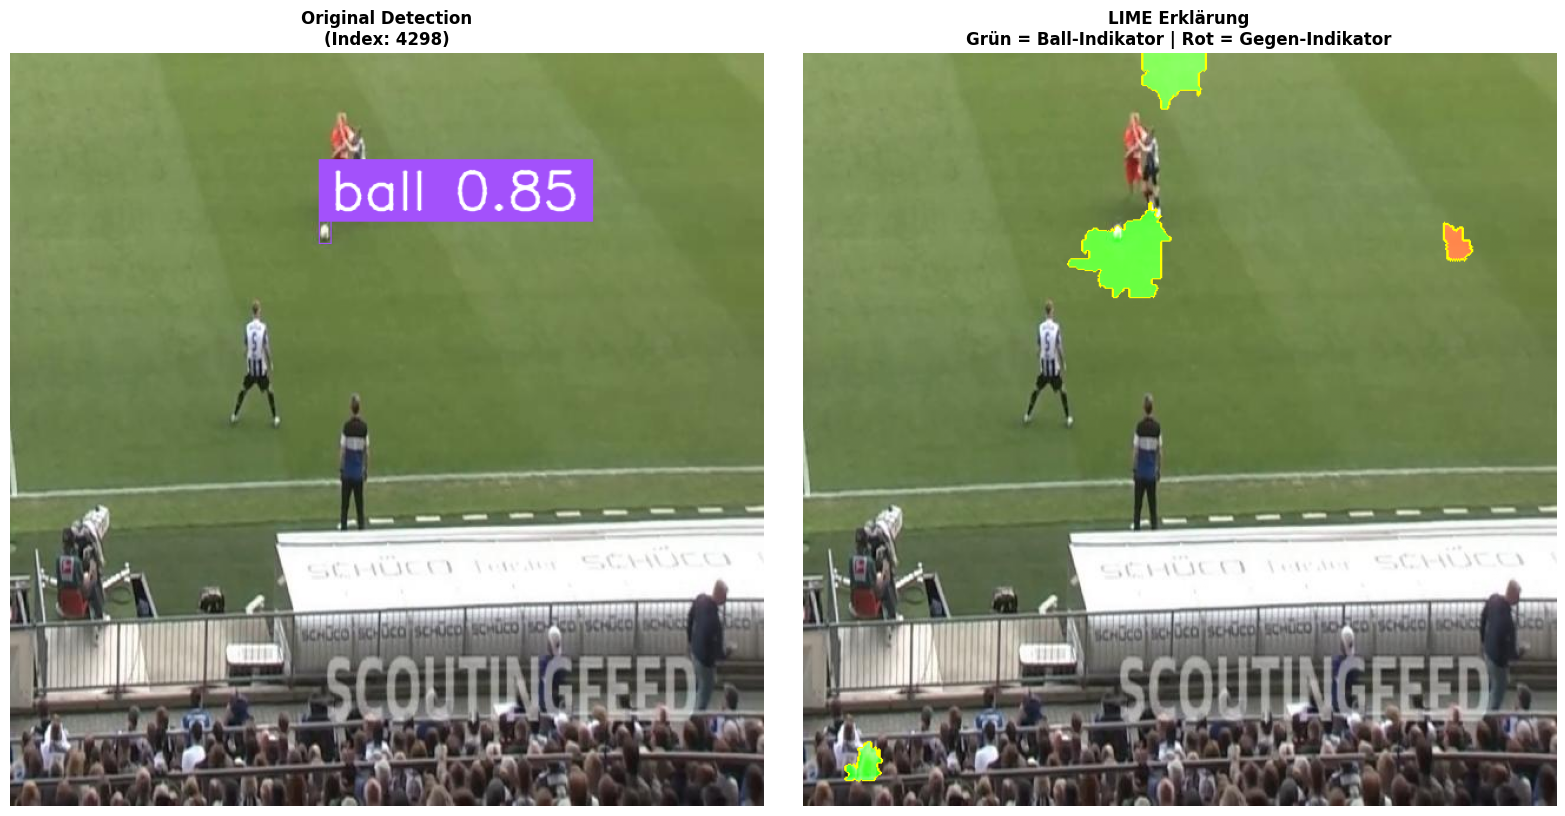

📝 Analyse beendet.



In [ ]:
# Aufruf mit 100 Durchläufen
analyze_with_lime(IMAGES_INDICES[0], num_samples=100)

Analysieren desselben Bildes mit denselben Durchläufen


🧐 STARTE ANALYSE FÜR BILD 4298
📂 Datei: c01561_0_mp4-0035_jpg.rf.9ac049933f21756fa94bc784059d28bf.jpg
⏳ LIME arbeitet... (100 Permutationen)
   Dies kann je nach CPU/GPU einige Sekunden dauern...


100%|██████████| 100/100 [06:49<00:00,  4.09s/it]


✓ LIME Berechnung erfolgreich!


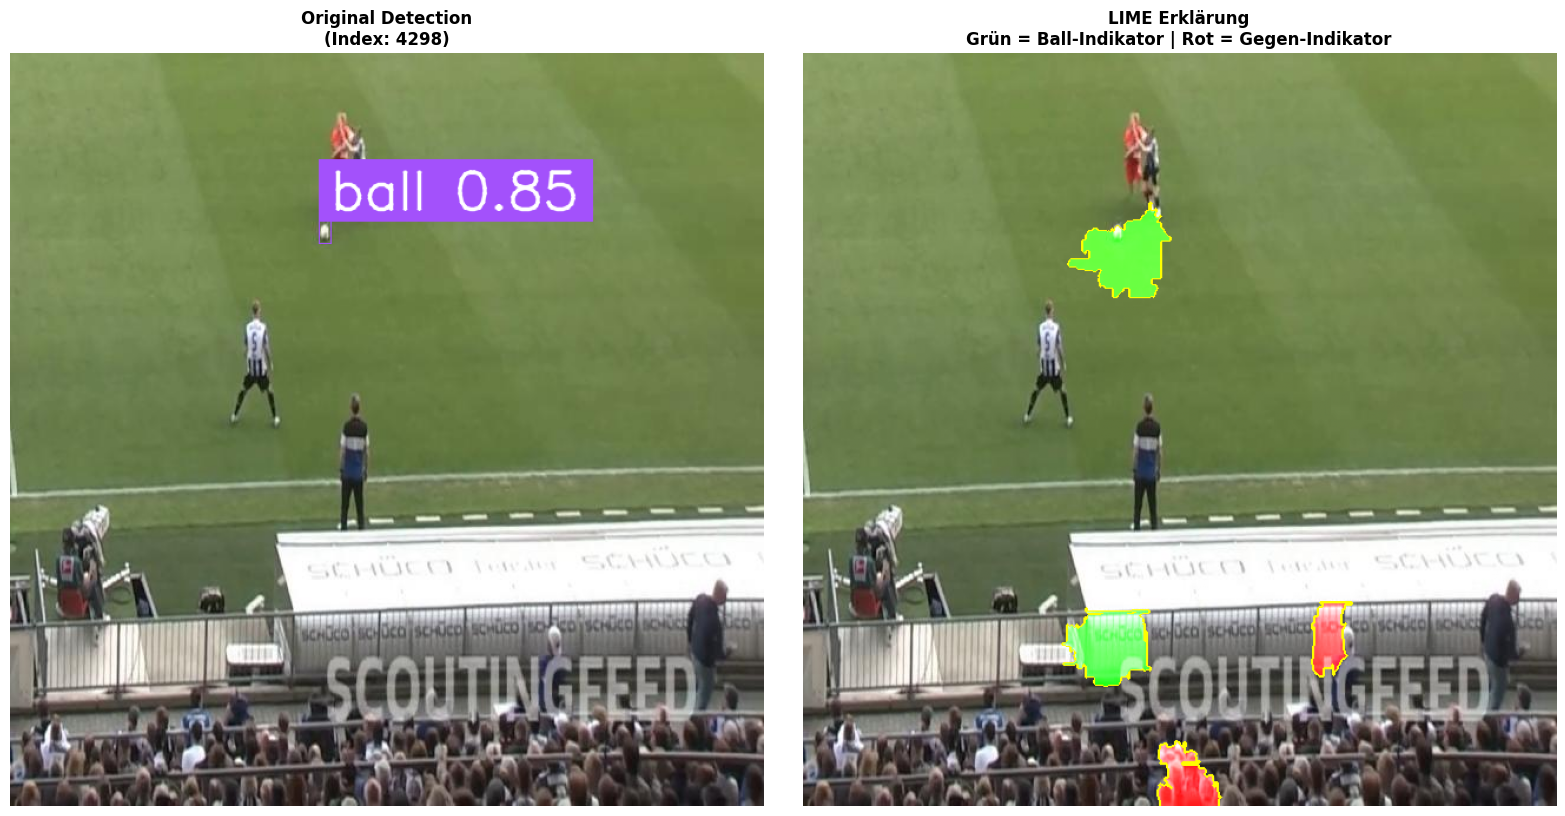

📝 Analyse beendet.



In [ ]:
# Analyse mit Parameter 100
analyze_with_lime(IMAGES_INDICES[0], 100)

Dies ist ein deutlich anderes Ergebnis als zuvor, obwohl dieselbe Anzahl an Durchläufen genommen wurde

### Verschiedene Anzahl Samples (Durchführungen)
Ein Parameter welches selbst gewählt werden muss. Daher möchte ich anfangs etwas damit zu experimentieren um ein Gefühl dafür zu bekommen in welcher Höhe mit großen Änderungen zu rechnen ist
- 100 (siehe Block zuvor)
- 200
- 300
- 500
- 700
- 1000

(Leider habe ich nicht unbegrenzt Rechenleistung 😊)


🧐 STARTE ANALYSE FÜR BILD 4298
📂 Datei: c01561_0_mp4-0035_jpg.rf.9ac049933f21756fa94bc784059d28bf.jpg
⏳ LIME arbeitet... (200 Permutationen)
   Dies kann je nach CPU/GPU einige Sekunden dauern...


100%|██████████| 200/200 [10:26<00:00,  3.13s/it]


✓ LIME Berechnung erfolgreich!


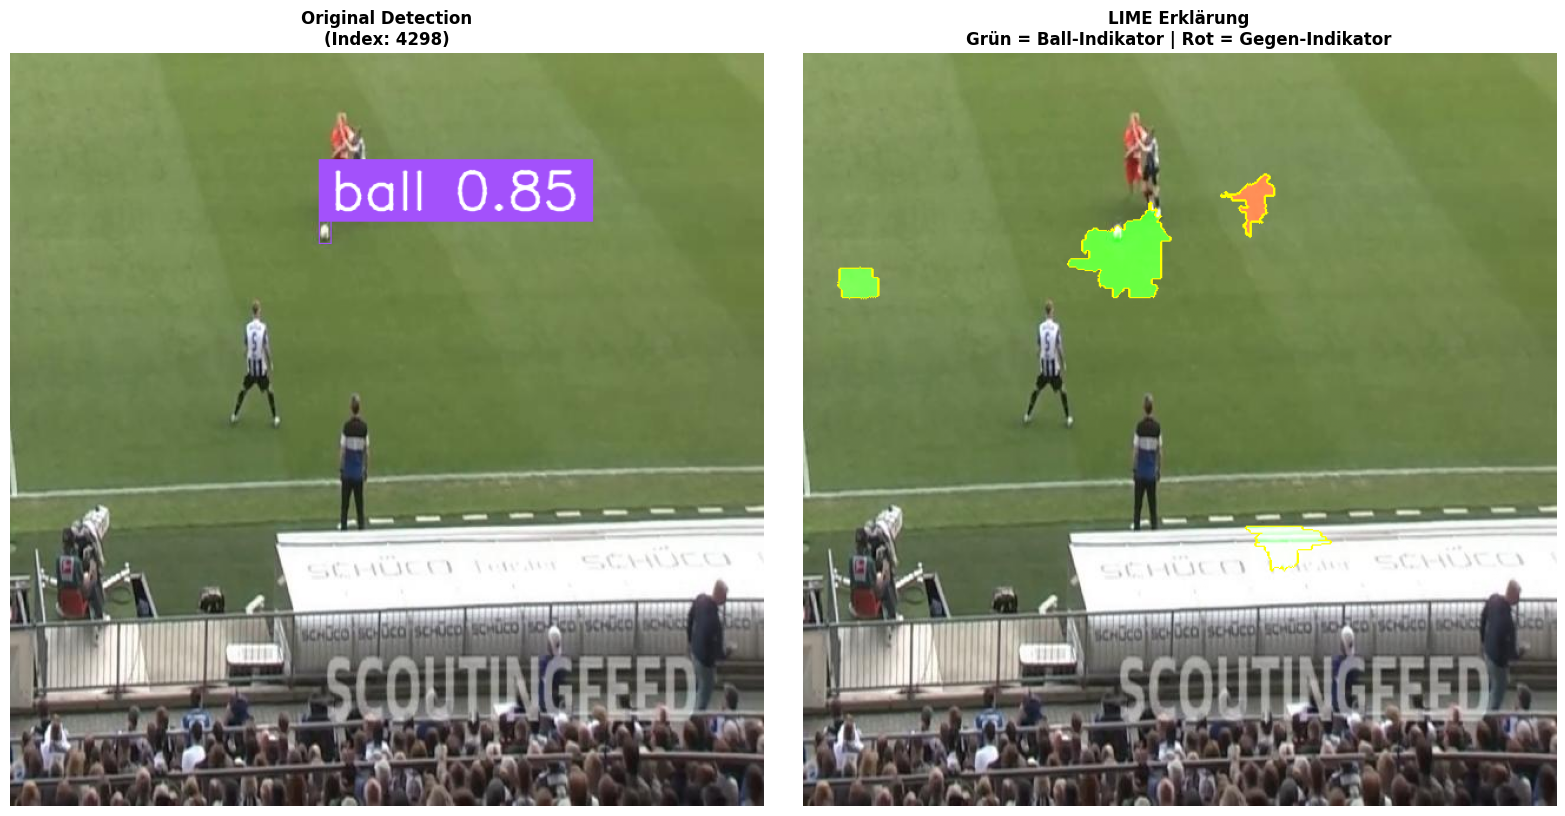

📝 Analyse beendet.



In [55]:
# Analyse mit Parameter 200
analyze_with_lime(IMAGES_INDICES[0], 200)


🧐 STARTE ANALYSE FÜR BILD 4298
📂 Datei: c01561_0_mp4-0035_jpg.rf.9ac049933f21756fa94bc784059d28bf.jpg
⏳ LIME arbeitet... (300 Permutationen)
   Dies kann je nach CPU/GPU einige Sekunden dauern...


100%|██████████| 300/300 [13:19<00:00,  2.66s/it]


✓ LIME Berechnung erfolgreich!


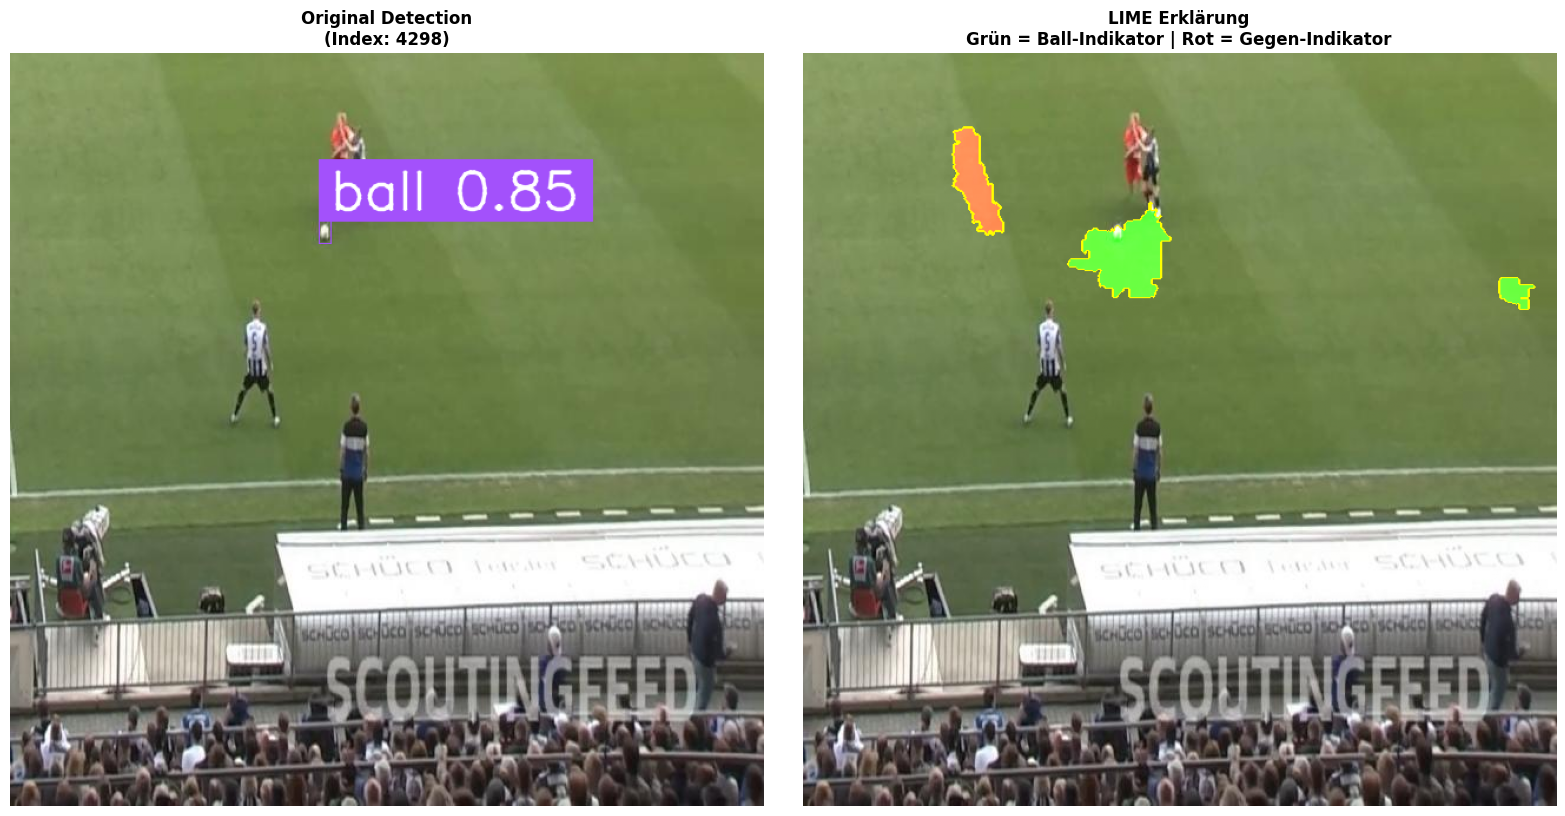

📝 Analyse beendet.



In [56]:
# Analyse mit Parameter 300
analyze_with_lime(IMAGES_INDICES[0], 300)

In [ ]:
# Analyse mit Parameter 500
analyze_with_lime(IMAGES_INDICES[0], 500)


🧐 STARTE ANALYSE FÜR BILD 4298
📂 Datei: c01561_0_mp4-0035_jpg.rf.9ac049933f21756fa94bc784059d28bf.jpg
⏳ LIME arbeitet... (500 Permutationen)
   Dies kann je nach CPU/GPU einige Sekunden dauern...


 64%|██████▎   | 318/500 [10:04<02:38,  1.15it/s]

In [ ]:
# Analyse mit Parameter 700
analyze_with_lime(IMAGES_INDICES[0], 700)

In [ ]:
# Analyse mit Parameter 1000
analyze_with_lime(IMAGES_INDICES[0], 1000)

Theoretisch könnte man natürlich bei jedem Bild unterschiedliche Anzahl an Durchläufen probieren. Dies ist allerdings im Rahmen dieses Projekts zu zeitaufwändig.